In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib.colors import PowerNorm

In [2]:
# Parameters
n_idvl = 32
n_char_loc = 8

In [3]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load data
df = pd.read_csv('../data/newport.csv', low_memory=False)
tr = pd.read_csv('../data/newport_melted.csv')

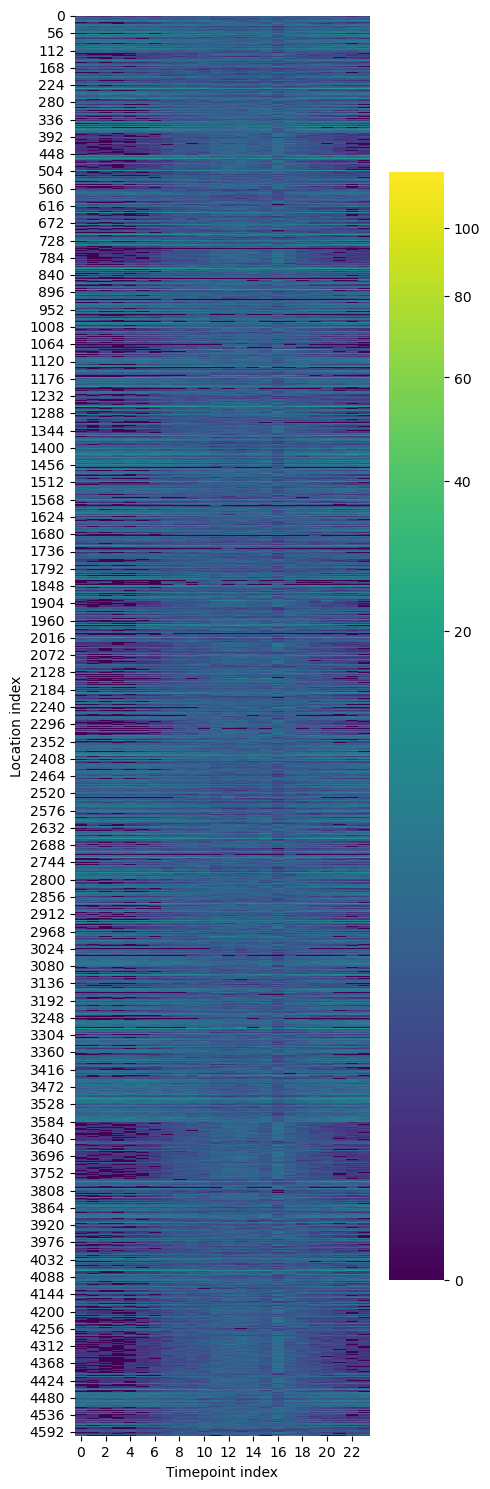

In [6]:
# Create city_target tensor

# Unique places and timepoints
timepoints = np.sort(tr['t'].unique())           
loc_ids = sorted(tr['loc_id'].unique())          
n_timepoint = len(timepoints)
n_location = len(loc_ids)

# Index maps
loc_id_to_idx = {lid: i for i, lid in enumerate(loc_ids)}
t_to_idx = {t: i for i, t in enumerate(timepoints)}

# Target tensor
city_target = torch.full((n_location, n_timepoint), float('nan'))

for _, row in tr.iterrows():
  l_idx = loc_id_to_idx[row['loc_id']]
  t_idx = t_to_idx[row['t']]
  city_target[l_idx, t_idx] = row['visits']

# Verify
verify_city_target = True
if verify_city_target:
  plt.figure(figsize=(5, 15))
  sns.heatmap(city_target.cpu().numpy(), cmap='viridis', cbar=True, norm = PowerNorm(gamma=0.3))

  plt.xlabel("Timepoint index")
  plt.ylabel("Location index")
  plt.tight_layout()
  plt.show()

In [22]:
# Randomly select n_char_loc locations for each individual
# Identify residential and nonresidential loc_ids
# Filter residential locations with their square footage
res_df = df[df['prim_occ'] == 'Single Family Dwelling']
res_locs = res_df['loc_id'].values
res_weights = res_df['sqfeet'].astype(float).values
res_weights /= res_weights.sum()  # Normalize to sum to 1

nonres_locs = df[df['prim_occ'] != 'Single Family Dwelling']['loc_id'].unique()

idvl_loc_ids = []
for _ in range(n_idvl):
    # Weighted sample of primary residential location
    res_loc = np.random.choice(res_locs, p=res_weights)

    # Determine count of nonresidential vs residential among the other locations
    n_other = n_char_loc - 1
    n_nonres = int(np.round(n_other * 0.9))
    n_res = n_other - n_nonres

    # Sample additional locations (excluding the already selected one)
    other_nonres = np.random.choice(
        nonres_locs, size=n_nonres, replace=False
    )
    other_res = np.random.choice(
        res_locs[res_locs != res_loc], size=n_res, replace=False
    )

    locs = [res_loc] + list(other_nonres) + list(other_res)
    idvl_loc_ids.append(locs)  # Residential first


# Verify
#for i, locs in enumerate(idvl_loc_ids):
#    print(f"Individual {i}: {locs}")
    
#df[df['loc_id'] == idvl_loc_ids[0][0]]

In [23]:
# Define nets
class IdvlNet(nn.Module):
    def __init__(self, n_char_loc):
        hidden_size = 32
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_char_loc),
            nn.Softmax(dim=-1)
        )

    def forward(self, t):  
        return self.net(t) 


class CityNet(nn.Module):
    def __init__(self, n_idvl, n_char_loc):
        super().__init__()
        self.subnets = nn.ModuleList([
            IdvlNet(n_char_loc) for _ in range(n_idvl)
        ])

    def forward(self, t):  # t: (T, 1)
        return torch.stack([net(t) for net in self.subnets], dim=0)


In [24]:
# Multinomial negative log likelihood
def multinomial_nll(p, x):
    eps = 1e-8 
    log_p = torch.log(p + eps)
    nll = -(x * log_p).sum()
    return nll

In [25]:
# Prepare to train a single individual to demonstrate that part of the pipeline

loc_ids_i = idvl_loc_ids[0]  # Choose individual 0
idx_i = [loc_id_to_idx[loc] for loc in loc_ids_i]  # Indices into city_target

# Verify dictionary mapping
print(loc_ids_i)
print([loc_ids[idx] for idx in idx_i])



[1302361, 1315101, 1310962, 1307042, 1307338, 1307022, 1307439, 1306031]
[1302361, 1315101, 1310962, 1307042, 1307338, 1307022, 1307439, 1306031]


In [26]:
# Initialize the model and optimizer

model = IdvlNet(n_char_loc)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [27]:
# Create input: normalized time tensor (T, 1)
t_vals = torch.tensor(timepoints, dtype=torch.float32).unsqueeze(1)  # shape: (T, 1)

# Extract target for this individual (locations indexed by idx_i)
target = city_target[idx_i, :].T  # shape: (T, n_char_loc)

# Training loop
n_epoch = 1000
for epoch in range(n_epoch):
    model.train()
    optimizer.zero_grad()

    pred = model(t_vals)  # shape: (T, n_char_loc)
    loss = multinomial_nll(pred, target)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")


Epoch 0: loss = 701.3705
Epoch 100: loss = 591.1893
Epoch 200: loss = 590.4950
Epoch 300: loss = 589.7254
Epoch 400: loss = 589.1903
Epoch 500: loss = 588.4345
Epoch 600: loss = 587.6285
Epoch 700: loss = 586.7048
Epoch 800: loss = 586.2317
Epoch 900: loss = 585.7192


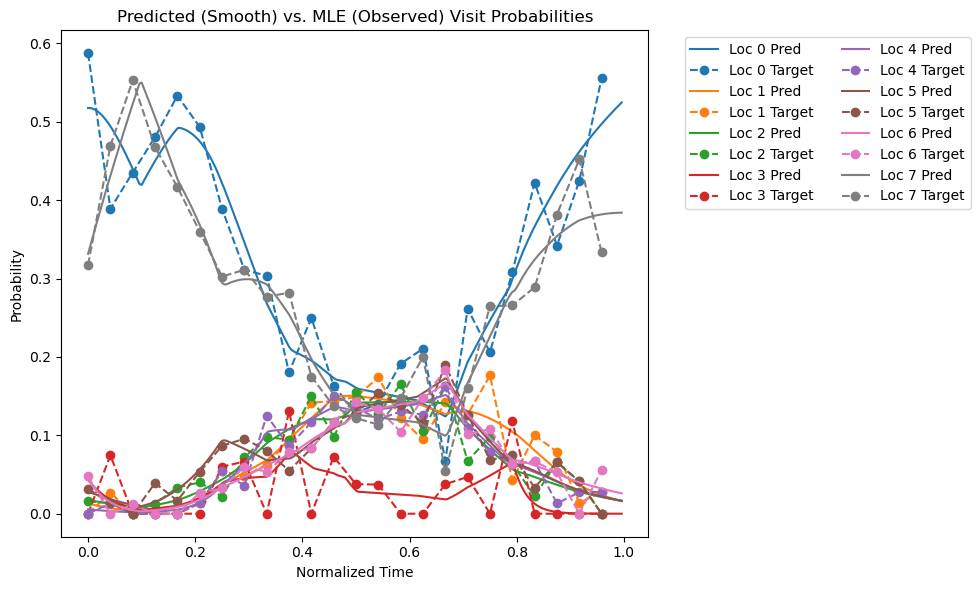

In [28]:
# Validation of training on a single individual:

## 1. Finely spaced time vector
n_fine = 240
t_fine = np.linspace(0, 1, n_fine, endpoint=False)   # shape (n_fine,)
t_fine_tensor = torch.tensor(t_fine, dtype=torch.float32).unsqueeze(1)  # (n_fine, 1)

## 2. Get model predictions for fine-grained times
model.eval()
with torch.no_grad():
    pred_fine = model(t_fine_tensor).numpy()  # (n_fine, n_char_loc)
    # Also get predictions for the original timepoints for reference (optional)
    pred_coarse = model(torch.tensor(timepoints, dtype=torch.float32).unsqueeze(1)).numpy()

## 3. Empirical probabilities at observed timepoints (MLE)
target_np = target.numpy()  # (T, n_char_loc)
target_probs = target_np / target_np.sum(axis=1, keepdims=True)  # (T, n_char_loc)

## 4. Plot: smooth predictions (solid), data (dashed/marker)
plt.figure(figsize=(10, 6))
colors = plt.colormaps['tab10']

for i in range(n_char_loc):
    color = colors(i % colors.N)
    plt.plot(t_fine, pred_fine[:, i], color=color, linestyle='-', label=f'Loc {i} Pred')
    plt.plot(timepoints, target_probs[:, i], color=color, linestyle='--', marker='o', label=f'Loc {i} Target')

plt.xlabel('Normalized Time')
plt.ylabel('Probability')
plt.title('Predicted (Smooth) vs. MLE (Observed) Visit Probabilities')
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
# Now for the entire city...

In [30]:
# Prepare input and target batches

t_vals = torch.tensor(timepoints, dtype=torch.float32).unsqueeze(1).to(device)  

targets = []
for i in range(n_idvl):
    idx_i = [loc_id_to_idx[loc] for loc in idvl_loc_ids[i]]
    targets.append(city_target[idx_i, :].T)
targets = torch.stack(targets, dim=0).to(device)  

In [31]:
# Optionally check 

do_check = False
if do_check:
  i = 0  # individual to check
  j = 2  # location to check

  loc_id = idvl_loc_ids[i][j]
  loc_idx = loc_id_to_idx[loc_id]

  # assembled targets for this training
  print("From targets tensor:")  
  print(targets[i, :, j].numpy())  # (T,)

  # master target 
  print("From city_target tensor:")   
  print(city_target[loc_idx, :].numpy())  # (T,)

In [32]:
# Initialize CityNet and optimizer
city_model = CityNet(n_idvl, n_char_loc).to(device)
optimizer = torch.optim.Adam(city_model.parameters(), lr=1e-2)

In [33]:
# Training
n_epoch = 1000
for epoch in range(n_epoch):
    city_model.train()
    optimizer.zero_grad()
    
    preds = city_model(t_vals)  # (n_idvl, T, n_char_loc)
    # Transpose to match targets shape (n_idvl, T, n_char_loc)
    preds = preds.permute(0, 1, 2)
    
    # Compute batched multinomial loss
    loss = 0.0
    for i in range(n_idvl):
        loss += multinomial_nll(preds[i], targets[i])
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: avg loss = {loss.item()/n_idvl:.4f}")

Epoch 0: avg loss = 880.3847
Epoch 100: avg loss = 605.5952
Epoch 200: avg loss = 602.1406
Epoch 300: avg loss = 601.0578
Epoch 400: avg loss = 600.2408
Epoch 500: avg loss = 599.6118
Epoch 600: avg loss = 599.1419
Epoch 700: avg loss = 598.7059
Epoch 800: avg loss = 598.2770
Epoch 900: avg loss = 597.9385


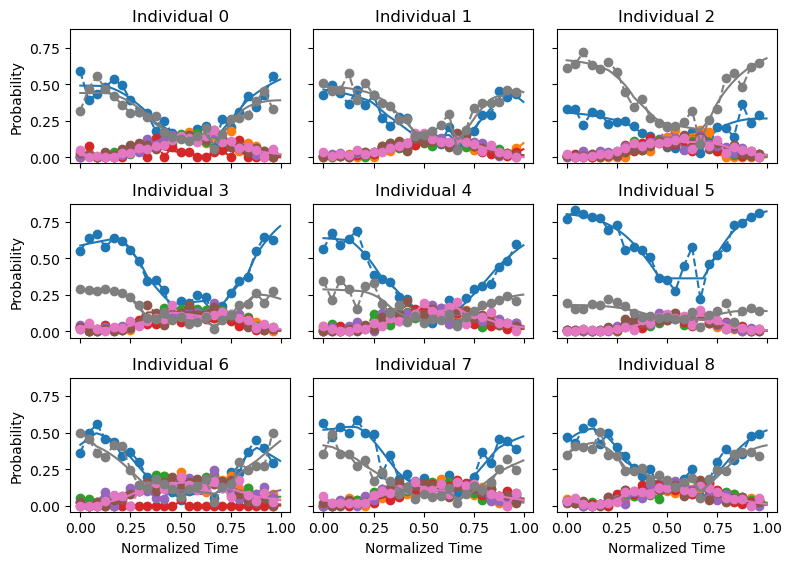

Predicted probabilities for individual 0 at t=0:
[0.4903608  0.00543849 0.00919469 0.01659626 0.00255921 0.02340378
 0.01312254 0.43932417]


In [34]:
# Validation

n_show = 9  # number of individuals to show
fine_times = np.linspace(0, 1, 240, endpoint=False)

city_model.eval()
with torch.no_grad():
  t_fine = torch.tensor(fine_times, dtype=torch.float32).unsqueeze(1).to(device)
  pred_fine = city_model(t_fine)
  pred_fine_np = pred_fine.numpy()

fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharex=True, sharey=True)
colors = plt.colormaps['tab10']

for idvl in range(n_show):
    ax = axes[idvl // 3, idvl % 3]

    target_np = targets[idvl].numpy()  
    target_probs = target_np / target_np.sum(axis=1, keepdims=True)
    for j in range(n_char_loc):
        color = colors(j % colors.N)
        ax.plot(fine_times, pred_fine_np[idvl, :, j], color=color, linestyle='-', label=f'Loc {j} Pred' if idvl == 0 else None)
        ax.plot(timepoints, target_probs[:, j], color=color, linestyle='--', marker='o', label=f'Loc {j} Target' if idvl == 0 else None)
    ax.set_title(f'Individual {idvl}')
    if idvl % 3 == 0:
        ax.set_ylabel('Probability')
    if idvl // 3 == 2:
        ax.set_xlabel('Normalized Time')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("Predicted probabilities for individual 0 at t=0:")
print(pred_fine_np[0, 0])


In [36]:
# Saving the model
torch.save(city_model.state_dict(), '../data/newport_weights_32.pth')

Predicted probabilities for individual 0 at t=0:
[0.4903608  0.00543849 0.00919469 0.01659626 0.00255921 0.02340378
 0.01312254 0.43932417]


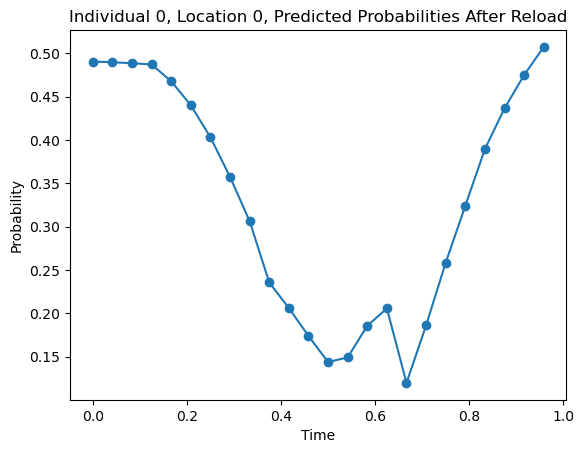

In [37]:
# Loading it back in and proving it still runs
city_model = CityNet(n_idvl, n_char_loc)
city_model.load_state_dict(torch.load('../data/newport_weights_32.pth'))
city_model.eval()

# Forward pass on coarse (training) timepoints
with torch.no_grad():
    preds = city_model(torch.tensor(timepoints, dtype=torch.float32).unsqueeze(1))  # (n_idvl, T, n_char_loc)

print("Predicted probabilities for individual 0 at t=0:")
print(preds[0, 0].cpu().numpy())

# Optionally, plot as additional confirmation (e.g., individual 0, all timepoints, location 0)
import matplotlib.pyplot as plt

plt.plot(timepoints, preds[0, :, 0].cpu().numpy(), marker='o')
plt.title('Individual 0, Location 0, Predicted Probabilities After Reload')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()
